In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cvxpy as cp
import copy
from EVFleet import * 
import pandas as pd
import sys

In [3]:
def create_energy_set(start, M, H, pv, wt):
    days = 365 // M -1
    q = np.zeros((M, H))
    Q = np.zeros((M, days * 24))
    for m in range(M):
        start_idx = m * days * 24
        end_idx = (m + 1) * days * 24
        Q[m, :] = pv[start_idx:end_idx] + wt[start_idx:end_idx]
        q[m, :] = Q[m, start:start+H]

    return q

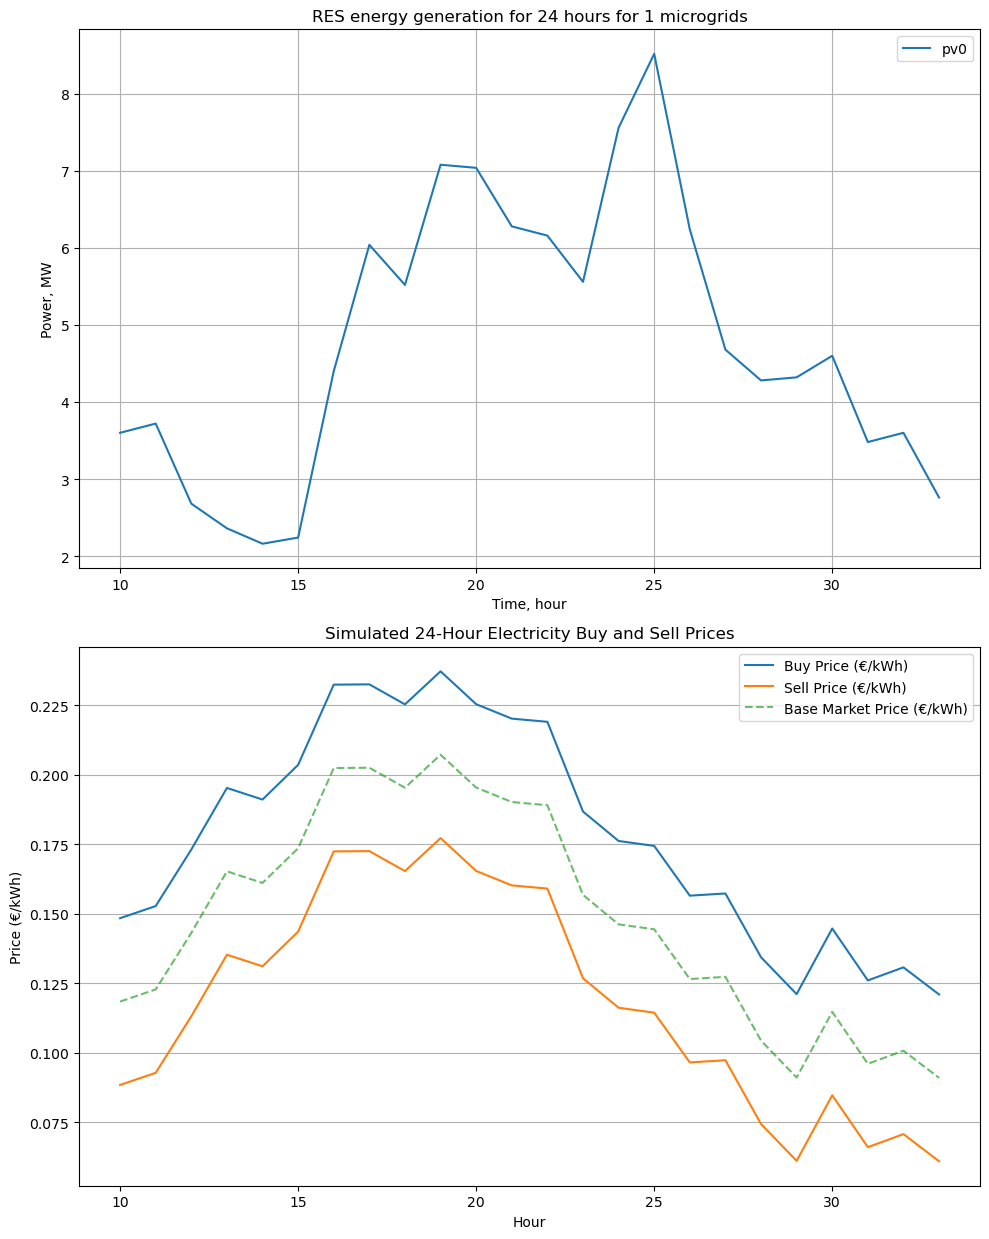

In [27]:
DAYS = 1
H=24
M=1
N=10
start = 10

# Set seed for reproducibility
np.random.seed(42)

hours = np.arange(start, start + 24 * DAYS)
base_price = 0.15
amplitude = 0.10

noise = np.random.normal(0, 0.01, size=24*DAYS)
# Symmetric price
prices = base_price + amplitude * (
    np.sin((hours - 8) / 24 * 2 * np.pi) + np.sin((hours - 18) / 24 * 2 * np.pi)
) + noise
prices = np.clip(prices, 0.05, None)
    
# Add asymmetric buy/sell prices
margin = 0.03
c = prices + margin
p = prices - margin
p = np.clip(p, 0.01, None)  # Prevent negative prices

# Load CSV data
pv_energy = '2023_photovoltaic_total_at.csv'  # Replace with your actual file path
wt_energy = '2023_windpower_total_at.csv'  # Replace with your actual file path

pv = pd.read_csv(pv_energy, delimiter=';')
wt = pd.read_csv(wt_energy, delimiter=';')

pv_arr = pv['Power (MW)'].to_numpy()
wt_arr = wt['Power (MW)'].to_numpy()


q = create_energy_set(start, M, H*DAYS, pv_arr, wt_arr) / 100

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 12.5))  # 1 row, 2 columns

axs[0].set_title(f'RES energy generation for {H*DAYS} hours for {M} microgrids')
for m in range(M): 
    axs[0].plot(np.arange(start, start+H*DAYS), q[m,:], label=f"pv{m}")
axs[0].legend()
axs[0].set_xlabel('Time, hour')
axs[0].set_ylabel('Power, MW')
axs[0].grid(True)
# First subplot: Buy and Sell Prices
axs[1].plot(hours, c, label='Buy Price (€/kWh)')
axs[1].plot(hours, p, label='Sell Price (€/kWh)')
axs[1].plot(hours, prices, label='Base Market Price (€/kWh)', linestyle='--', alpha=0.7)
axs[1].set_title("Simulated 24-Hour Electricity Buy and Sell Prices")
axs[1].set_xlabel("Hour")
axs[1].set_ylabel("Price (€/kWh)")
axs[1].grid(axis='y')
axs[1].legend()

plt.tight_layout()
plt.savefig("MPC environmental parameters", dpi=300)
plt.show()

In [64]:
fleet = EVFleet(xlsx_path='EV_UsageProfile.xlsx', num_vehicles=N*M)
results = fleet.simulate_multiple_days(num_days=DAYS)
N = 10
M = 1
L_usage_global = np.zeros((M,N,DAYS+1,4), dtype='int')
for row in results:
    L_usage_global[row['EV'] // N, row['EV'] % N, row['Day']-1, 0] = int(row['Initial SoC']) / 100
    L_usage_global[row['EV'] // N, row['EV'] % N, row['Day']-1, 1] = int(row['Goal (kWh)']) / 100
    L_usage_global[row['EV'] // N, row['EV'] % N, row['Day']-1, 2] = int(row['Arrival (h)']) + 24 * (row['Day'] - 1) - start
    #L_usage_global[row['EV'] // N, row['EV'] % N, row['Day']-1, 3] = int(row['Departure (h)']) + 24 * (row['Day']) - start if int(row['Departure (h)']) + 24 * (row['Day'])  - start < 23 + 24 * (row['Day']) -start  else 21 + 24 * (row['Day']) - start
    L_usage_global[row['EV'] // N, row['EV'] % N, row['Day']-1, 3] = int(row['Departure (h)']) + 24 * (row['Day']) - start if int(row['Departure (h)']) + 24 * (row['Day']) - start < 23 else 22
    print(row['EV'] // N, row['EV'] % N, L_usage_global[row['EV'] // N, row['EV'] % N, row['Day']-1, :])
    

0 0 [17 80  6 20]
0 1 [11 80  6 20]
0 2 [11 80  7 21]
0 3 [17 80  4 21]
0 4 [14 80  4 21]
0 5 [14 80  7 21]
0 6 [14 80  6 20]
0 7 [11 80  7 21]
0 8 [19 80  6 20]
0 9 [18 40  0 22]


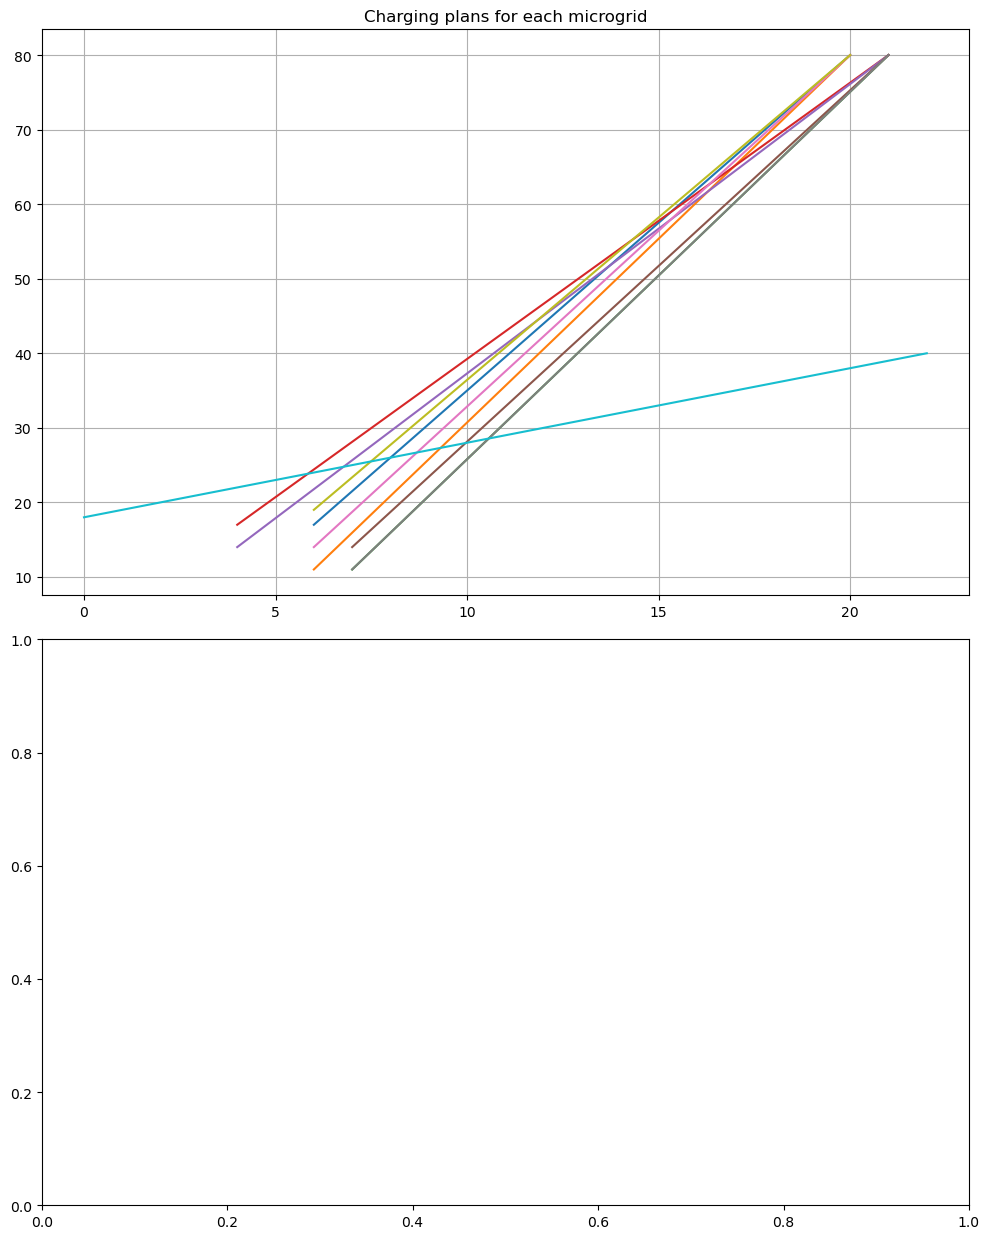

In [66]:
fig, axs = plt.subplots(2, 1, figsize=(10,12.5))
for d in range(DAYS):
    for m in range(M):
        for n in range(N):
            L_init, L_target, L_arrival, L_dep = L_usage_global[m,n,d,:]
            y = [L_init, L_target]
            x = [L_arrival, L_dep]
            axs[m].plot(x,y)
            axs[m].grid(True)
axs[0].set_title("Charging plans for each microgrid");
plt.tight_layout()
plt.savefig("Charging plans for each microgrid", dpi=300)
plt.show()

L_target = L_usage_global[:,:,0,1]
L_init = L_usage_global[:,:,0,0]
L_arrival = L_usage_global[:,:,0,2]
L_depart = L_usage_global[:,:,0,3]

In [68]:
class Battery_Agent:
    def __init__(self, idx,  H=24, rho=1.8, gamma=0.1, epsilon=0.1, L_min=0, L_max=5000, d_min=0, d_max=1000, f_min=0, f_max=1000, l_min=0, l_max=1000, m_min=0, m_max=1000):
        self.H = H
        self.rho = rho
        self.gamma = gamma
        self.epsilon = epsilon
        self.idx = idx
        self.c1 = c1 = 5
        
        L_min = np.ones((H)) * L_min
        L_max = np.ones((H)) * L_max
        
        d_min = np.ones((H)) * d_min
        d_max = np.ones((H)) * d_max
        
        f_min = np.ones((H)) * f_min
        f_max = np.ones((H)) * f_max
        
        l_min = np.ones((H)) * l_min
        l_max = np.ones((H)) * l_max
        
        m_min = np.ones((H)) * m_min
        m_max = np.ones((H)) * m_max
        
    def update(self, lambdas, H_n_T_x, L_init, q, c, p, d, H):
        
        
        constraints = []
        xi = cp.Variable(5*H)
        d = xi[:H]
        f = xi[H:2*H]
        l = xi[2*H:3*H]
        m = xi[3*H:4*H]
        L = xi[4*H:]

        start_time = L_arrival
        end_time = int(L_depart)

        net_cost = cp.sum(cp.multiply(c, d) / q - cp.multiply(p, f) / q)

        h_n_T_x = -d + f + l - m

        admm_penalty = (self.rho / 2) *  cp.sum_squares(h_n_T_x  + cp.sum(H_n_T_x,axis=0) - H_n_T_x[self.idx] - q - 1/self.rho * lambdas)

        admm_update = 5.5 *cp.sum_squares(xi - x_prev)

        objective = cp.Minimize(c1*net_cost + admm_penalty +  admm_update)

        # Constraints
        constraints += [
            L >= L_min,
            L <= L_max,
            d >= d_min,
            d <= d_max,
            f >= f_min,
            f <= f_max,
            l >= l_min,
            l <= l_max,
            m >= m_min,
            m <= m_max
        ]
        
        constraints += [
             L[L_arrival] == L_init + l[L_arrival] - m[L_arrival]
        ]
        
        for h in range(1, H):
            constraints += [
                L[h] == L[h-1] + l[h] - m[h],
                cp.abs(l[h-1] - l[h]) <= 500,
                cp.abs(m[h-1] - m[h]) <= 500,
                cp.abs(d[h-1] - d[h]) <= 500,
                cp.abs(f[h-1] - f[h]) <= 500,
            ]
            
        for h in range(H):
                if h >= L_depart:
                    constraints += [
                        l[h] == 0,
                        m[h] == 0,
                        d[h] == 0
                    ]
                if h <= L_arrival:
                    constraints += [
                        l[h] == 0,
                        m[h] == 0,
                        d[h] == 0
                    ]
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.OSQP, warm_start=True)
        return xi.value, h_n_T_x.value

In [70]:
class EV_Agent:
    def __init__(self, idx,  H=24, rho=1.8, gamma=0.1, epsilon=0.1, L_min=0, L_max=100, d_min=0, d_max=10, f_min=0, f_max=10, l_min=0, l_max=10, m_min=0, m_max=10):
        self.H = H
        self.rho = rho
        self.gamma = gamma
        self.epsilon = epsilon
        self.idx = idx
        self.c1 = c1 = 5
        
        self.L_min = L_min
        self.L_max = L_max
        
        self.d_min = d_min
        self.d_max = d_max
        
        self.f_min = f_min
        self.f_max = f_max
        
        self.l_min = l_min
        self.l_max = l_max
        
        self.m_min = m_min
        self.m_max = m_max
        
    def update(self, lambdas, H_n_T_x, L_usage, x_prev, parameters_init, q, c, p, d, H):

        L_min = np.ones((H)) * self.L_min
        L_max = np.ones((H)) * self.L_max
        
        d_min = np.ones((H)) * self.d_min
        d_max = np.ones((H)) * self.d_max
        
        f_min = np.ones((H)) * self.f_min
        f_max = np.ones((H)) * self.f_max
        
        l_min = np.ones((H)) * self.l_min
        l_max = np.ones((H)) * self.l_max
        
        m_min = np.ones((H)) * self.m_min
        m_max = np.ones((H)) * self.m_max
        
        L_target = L_usage[1]
        L_init = L_usage[0]
        L_arrival = L_usage[2]
        L_depart = L_usage[3]
        
        constraints = []
        xi = cp.Variable(5*H)
        d = xi[:H]
        f = xi[H:2*H]
        l = xi[2*H:3*H]
        m = xi[3*H:4*H]
        L = xi[4*H:]

        start_time = int(L_arrival)
        end_time = int(L_depart)

        net_cost = cp.sum(cp.multiply(c, d) / q - cp.multiply(p, f) / q)

        charge_penalty = cp.sum_squares(L[end_time] - L_target)

        h_n_T_x = -d + f + l - m

        admm_penalty = (self.rho / 2) *  cp.sum_squares(h_n_T_x  + cp.sum(H_n_T_x,axis=0) - H_n_T_x[self.idx] - q - 1/self.rho * lambdas)

        admm_update = 5.5 *cp.sum_squares(xi - x_prev)

        objective = cp.Minimize(self.c1 * net_cost + charge_penalty + admm_penalty +  admm_update)

        # Constraints
        constraints += [
            L >= L_min,
            L <= L_max,
            d >= d_min,
            d <= d_max,
            f >= f_min,
            f <= f_max,
            l >= l_min,
            l <= l_max,
            m >= m_min,
            m <= m_max
        ]

        constraints += [
            cp.abs(parameters_init[0] - d[0]) <= 5,
            cp.abs(parameters_init[1] - f[0]) <= 5,
            cp.abs(parameters_init[2] - l[0]) <= 5,
            cp.abs(parameters_init[3] - m[0]) <= 5,
        ]
        
        
        constraints += [
             L[0] == L_init + l[0] - m[0]
        ]
        
        for h in range(1, H):
            constraints += [
                L[h] == L[h-1] + l[h] - m[h],
                cp.abs(l[h-1] - l[h]) <= 5,
                cp.abs(m[h-1] - m[h]) <= 5,
                cp.abs(d[h-1] - d[h]) <= 5,
                cp.abs(f[h-1] - f[h]) <= 5,
            ]
            
        for h in range(H):
                if h >= L_depart:
                    constraints += [
                        l[h] == 0,
                        m[h] == 0,
                        d[h] == 0
                    ]
                """
                if h <= L_arrival:
                    constraints += [
                        l[h] == 0,
                        m[h] == 0,
                        d[h] == 0
                    ]
                """
        prob = cp.Problem(objective, constraints)
        prob.solve(solver=cp.OSQP, warm_start=True)
        #print(charge_penalty.value)
        return xi.value, h_n_T_x.value, charge_penalty.value

In [110]:
def environment_simulation(N=10, N_idx=None, EV_agents=None, 
                           Ba_agents=None, Nb=0, day=0, H=24, t=0, p=None, 
                           c=None, q=None, L_usage=None, L_usage_battery=None, 
                           gamma=None, rho=None, parameters_init = None):
    iteration = 0
    epsilon = 0.08
    x = np.array([np.zeros(5*H) for _ in range(N+Nb)])  # d, f, l, m, L[1:]
    lambdas = np.zeros(H)

    x_prev = copy.deepcopy(x)

    H_n_T_x = np.zeros((10,H))
    H_n_T_xi = np.zeros((10,H))
    
    #print(H_n_T_x)
    while True:
        iteration += 1
        charge_penalty_list = []
        for n, i in enumerate(N_idx):
            x[n], H_n_T_xi[n], charge_penalty = EV_agents[i].update(lambdas = lambdas,
                                                    H_n_T_x = H_n_T_x.copy(),
                                                    L_usage = L_usage[i], #We put [L_init,L_target,L_arrival,L_depart]
                                                    x_prev = x_prev[n],
                                                    parameters_init = parameters_init[i], #We put initial values for d,f,l,m
                                                    q = q, 
                                                    c = c,
                                                    p = p,
                                                    d = d,
                                                    H = H) 
            #print(i, parameters_init[i])
            #print("\n")
        """                                                
        elif n in Nb_idx:
                x[n], H_n_T_xi[n] = Ba_agents[n].update(lambdas = lambdas[n],
                                                        H_n_T_x = H_n_T_x,
                                                        L_usage = L_usage_battery[n],
                                                        q = q, 
                                                        c = c,
                                                        p = p,
                                                        d = d,
                                                        H = H)
        """
        H_n_T_x = copy.deepcopy(H_n_T_xi)
        lambdas -= gamma * rho * (np.sum(H_n_T_x, axis=0) - q)
        if charge_penalty is not None:
            charge_penalty_list.append(charge_penalty)
        else: 
            print("None")
        
        #print("--------------------------------------------")
        #print(f"ITERATION: {iteration}, active number: {N}, difference: {np.linalg.norm(x-x_prev)}, lambda {np.linalg.norm(np.sum(H_n_T_x, axis=0) - q)}")
        #print("--------------------------------------------")
        #print(f" ")
        sys.stdout.write(f"\rITERATION: {iteration}, active number: {N}, difference: {np.linalg.norm(x-x_prev):.4f}, lambda: {np.linalg.norm(np.sum(H_n_T_x, axis=0) - q):.4f}, charge penalty: {np.mean(np.array(charge_penalty_list)):.2f}")
        sys.stdout.flush()
        
        if np.linalg.norm(x-x_prev) <= epsilon:
            break
    
        x_prev = copy.deepcopy(x)
    print("\n")
    return x

In [112]:
N=10
Nb=0
H=24

rho = 0.1
gamma = 0.01

EV_agents = {n : EV_Agent(idx=n, rho=rho, gamma=gamma) for n in range(N)}
Ba_agents = {n : Battery_Agent(idx=n, rho=rho, gamma=gamma) for n in range(Nb)}


L_initial = np.zeros(N)
L_usage = np.zeros((N,4))

L_usage_battery = np.zeros((N))
parameters_init = np.array([np.zeros(4) for n in range(N)]) # d, f, l, m, L[1:]

# Collect data for plotting
d_history = np.array([np.zeros(DAYS * 24) for n in range(N)])
f_history = np.array([np.zeros(DAYS * 24) for n in range(N)])
l_history = np.array([np.zeros(DAYS * 24) for n in range(N)])
m_history = np.array([np.zeros(DAYS * 24) for n in range(N)])
L_history = np.array([np.zeros(DAYS * 24) for n in range(N)])


for t in range(DAYS * 24):
    d = t // 24
    N_idx = []
    
    for n in range(N):
        if L_usage_global[0,n,d,2] == t:
            N_idx.append(n)
            L_usage[n,0] = copy.deepcopy(L_usage_global[0,n,d,0]) #initial value of battery
            L_usage[n,1] = copy.deepcopy(L_usage_global[0,n,d,1]) #target value of battery
            L_usage[n,2] = 0 #Arrival time
            L_usage[n,3] = copy.deepcopy(L_usage_global[0,n,d,3]) - t #departure time 
            parameters_init[n,:] = np.array([0,0,0,0]) #initial parameters are zeros 
        elif L_usage_global[0,n,d,2] < t and t < L_usage_global[0,n,d,3]:
            L_usage[n,0] = copy.deepcopy(L_usage_battery[n])
            L_usage[n,1] = copy.deepcopy(L_usage_global[0,n,d,1]) #target value of battery
            L_usage[n,2] = 0 #Arrival time
            L_usage[n,3] = copy.deepcopy(L_usage_global[0,n,d,3]) - t #departure time 
            N_idx.append(n)
            parameters_init[n,0] = d_history[n][t-1] #initial parameters from previous timestep
            parameters_init[n,1] = f_history[n][t-1] #initial parameters from previous timestep
            parameters_init[n,2] = l_history[n][t-1] #initial parameters from previous timestep
            parameters_init[n,3] = m_history[n][t-1] #initial parameters from previous timestep
        else:
            L_usage_battery = np.zeros((N))
            
        print("GLOBAL: ", L_usage_global[0,n,d,:])
        print(f"Time: {t}; Battery information: Initial: {L_usage[n,0]}, Target: {L_usage[n,1]}, Arrival: {L_usage[n,2]}, Departure: {L_usage[n,3]}")        
    print("\n")
    #print("parameters: ", parameters_init)
    H = min(24,DAYS * 24-t)
    x = np.zeros((N,5*H))
    print(N_idx)
    if len(N_idx) != 0:
        
        x = environment_simulation(N=len(N_idx), 
                                   N_idx=N_idx,
                                   EV_agents=EV_agents,
                                   Ba_agents=Ba_agents,
                                   Nb=0, 
                                   day=d, 
                                   H=H, 
                                   t=t, 
                                   p=p[t:t+H], 
                                   c=c[t:t+H], 
                                   q=q[0][t:t+H], 
                                   L_usage=L_usage,
                                   L_usage_battery=L_usage_battery,
                                   gamma = gamma,
                                   rho = rho,
                                   parameters_init = parameters_init)

    
    for n, i in enumerate(N_idx):
        L_usage_battery[i] = x[n][4*H]
        d_history[i][t] = x[n][0*H]
        f_history[i][t] = x[n][1*H]
        l_history[i][t] = x[n][2*H]
        m_history[i][t] = x[n][3*H]
        L_history[i][t] = x[n][4*H]
        print(i, d_history[i][t], f_history[i][t], l_history[i][t], m_history[i][t])
        
    print(f"After time {t} battery load {L_usage_battery} \n")

    
        
        #L_usage_battery = x[:-Nb][4*H+1]
    


GLOBAL:  [17 80  6 20]
Time: 0; Battery information: Initial: 0.0, Target: 0.0, Arrival: 0.0, Departure: 0.0
GLOBAL:  [11 80  6 20]
Time: 0; Battery information: Initial: 0.0, Target: 0.0, Arrival: 0.0, Departure: 0.0
GLOBAL:  [11 80  7 21]
Time: 0; Battery information: Initial: 0.0, Target: 0.0, Arrival: 0.0, Departure: 0.0
GLOBAL:  [17 80  4 21]
Time: 0; Battery information: Initial: 0.0, Target: 0.0, Arrival: 0.0, Departure: 0.0
GLOBAL:  [14 80  4 21]
Time: 0; Battery information: Initial: 0.0, Target: 0.0, Arrival: 0.0, Departure: 0.0
GLOBAL:  [14 80  7 21]
Time: 0; Battery information: Initial: 0.0, Target: 0.0, Arrival: 0.0, Departure: 0.0
GLOBAL:  [14 80  6 20]
Time: 0; Battery information: Initial: 0.0, Target: 0.0, Arrival: 0.0, Departure: 0.0
GLOBAL:  [11 80  7 21]
Time: 0; Battery information: Initial: 0.0, Target: 0.0, Arrival: 0.0, Departure: 0.0
GLOBAL:  [19 80  6 20]
Time: 0; Battery information: Initial: 0.0, Target: 0.0, Arrival: 0.0, Departure: 0.0
GLOBAL:  [18 40  0 

In [78]:
N_idx

[9]

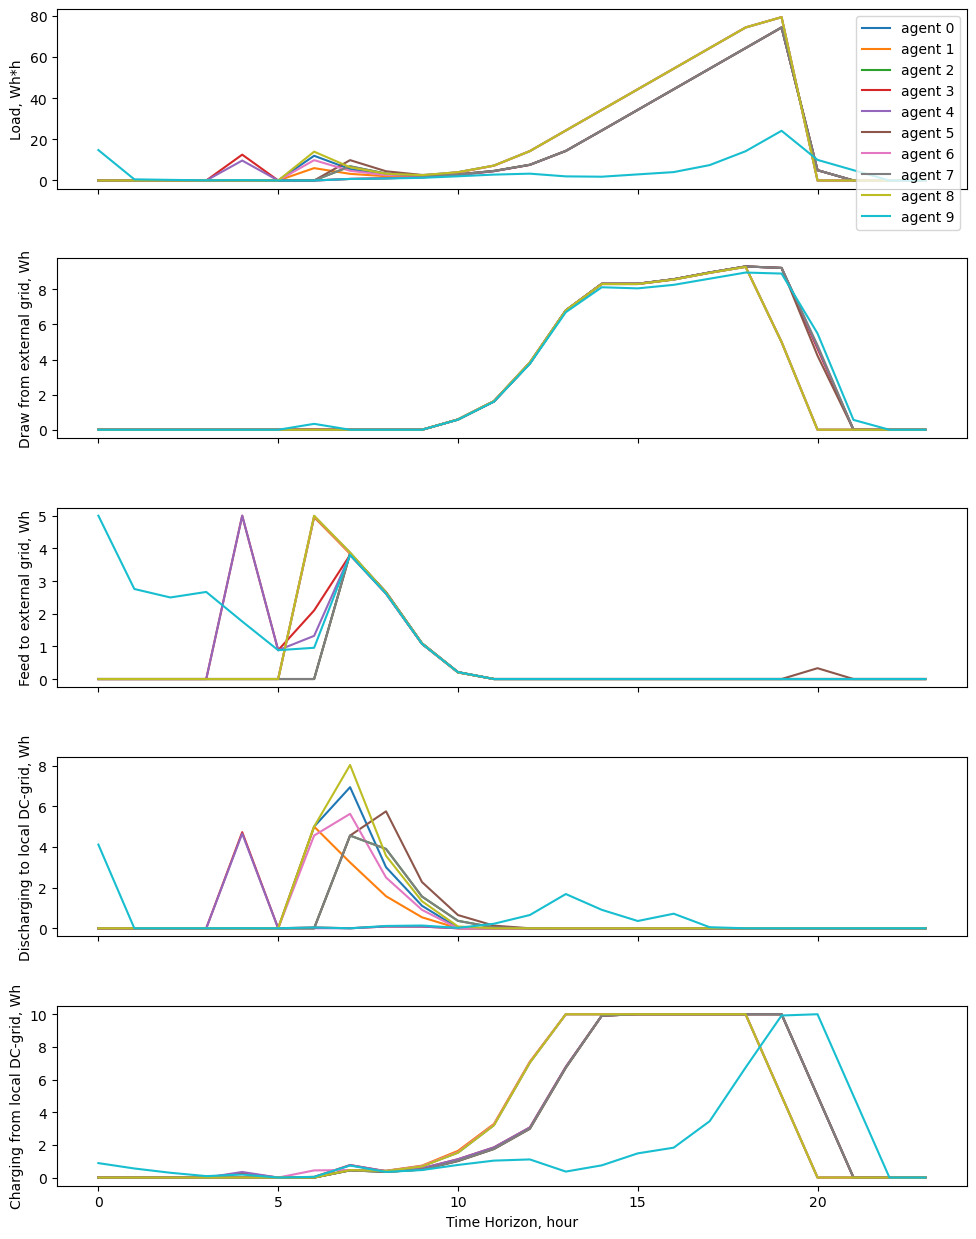

In [143]:
# Plotting
fig, axes = plt.subplots(5, 1, figsize=(10, 5*2.5), sharex=True)

for n in range(N):
    #axes[0].plot(np.full(H,L_target[n]))
    axes[0].plot(L_history[n], label =f'agent {n}')
    axes[0].grid(axis='y')
    axes[0].legend()
    axes[0].set_ylabel("Load, Wh*h")

for n in range(N):
    axes[1].plot(d_history[n])
    axes[1].grid(axis='y')
    axes[1].set_ylabel("Draw from external grid, Wh")

for n in range(N):
    axes[2].plot(f_history[n])
    axes[2].grid(axis='y')
    axes[2].set_ylabel("Feed to external grid, Wh")
    
for n in range(N):
    axes[3].plot(m_history[n])
    axes[3].grid(axis='y')
    axes[3].set_ylabel("Discharging to local DC-grid, Wh")
    
for n in range(N):
    axes[4].plot(l_history[n])
    axes[4].grid(axis='y')
    axes[4].set_ylabel("Charging from local DC-grid, Wh")
    

axes[-1].set_xlabel('Time Horizon, hour')
plt.tight_layout()
plt.savefig("MPC Decentralised framework with data", dpi=300)
plt.show()

In [135]:
for n in range(N):
    print(L_usage_global[0,n,0,3])
    print(f"Error between target and real load of {1+n} agent is {100 * (L_usage_global[0,n,0,1] - L_history[n][L_usage_global[0,n,0,3] - 1])/L_usage_global[0,n,0,1]:.2f}%")



20
Error between target and real load of 1 agent is 0.90%
20
Error between target and real load of 2 agent is 0.90%
21
Error between target and real load of 3 agent is 93.75%
21
Error between target and real load of 4 agent is 93.75%
21
Error between target and real load of 5 agent is 93.75%
21
Error between target and real load of 6 agent is 93.75%
20
Error between target and real load of 7 agent is 0.90%
21
Error between target and real load of 8 agent is 93.75%
20
Error between target and real load of 9 agent is 0.90%
22
Error between target and real load of 10 agent is 87.50%


In [137]:
total_cost = 0

cost = np.sum(c * d_history / q[0] - p * f_history / q[0]) #+ (L_target - L_history[:,-1]).T@(L_target - L_history[:,-1])
print(cost)

14.605266081021252


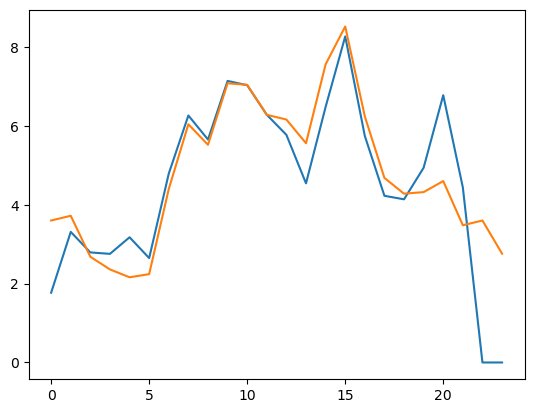

In [140]:
plt.plot(-np.sum(d_history,axis=0)+np.sum(f_history,axis=0)+np.sum(l_history,axis=0)-np.sum(m_history,axis=0))
plt.plot(q[0])